<a href="https://colab.research.google.com/github/mraith11/UMDAOSC650/blob/main/AOSC650_Final_Project_FV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Project for AOSC650**
Using an artificial neural network to identfy mineralogy from mass spectra








Start by importing key libraries (numpy, pandas, keras, etc.)

In [ ]:
## Import essential libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import sklearn
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split

Mount to google drive and read in the files. Each file has ~40,000 mass spectra from single scans (samples) with ~200 intensities corresponding to the ~200 masses listed in the mass list (features)

In [ ]:
## Mount to google drive
from google.colab import drive
drive.mount('/content/drive')

## Load in the csv datasets
augt = pd.read_csv('/content/drive/MyDrive/AOSC650_Dataset/augt_sn_dataset.csv').values
verm = pd.read_csv('/content/drive/MyDrive/AOSC650_Dataset/verm_sn_dataset.csv').values
labr = pd.read_csv('/content/drive/MyDrive/AOSC650_Dataset/labr_sn_dataset.csv').values
lizd = pd.read_csv('/content/drive/MyDrive/AOSC650_Dataset/lizd_sn_dataset.csv').values
oliv = pd.read_csv('/content/drive/MyDrive/AOSC650_Dataset/oliv_sn_dataset.csv').values
magn = pd.read_csv('/content/drive/MyDrive/AOSC650_Dataset/magn_sn_dataset.csv').values
nont = pd.read_csv('/content/drive/MyDrive/AOSC650_Dataset/nont_sn_dataset.csv').values

mass_list = pd.read_csv('/content/drive/MyDrive/AOSC650_Dataset/Mass_list.txt')


Mounted at /content/drive


In [ ]:
# Set random seed for reproducibility
np.random.seed(789)

The dataset does not have labels on it yet, so intenger labels are added here for simplicity - these are later transformed to one-hot-encoded labels, as there is no clear relationship between these minerals

In [ ]:
## Create labels, listed in the first row
augt_l = np.full((1,augt.shape[1]), 1)
augt_w_l = np.append(augt_l, augt, axis = 0) # labels in the first row
verm_l = np.full((1,verm.shape[1]), 2)
verm_w_l = np.append(verm_l, verm, axis = 0) # labels in the first row
oliv_l = np.full((1,oliv.shape[1]), 3)
oliv_w_l = np.append(oliv_l, oliv, axis = 0) # labels in the first row
labr_l = np.full((1,labr.shape[1]), 4)
labr_w_l = np.append(labr_l, labr, axis = 0) # labels in the first row
lizd_l = np.full((1,lizd.shape[1]), 5)
lizd_w_l = np.append(lizd_l, lizd, axis = 0) # labels in the first row
nont_l = np.full((1,nont.shape[1]), 6)
nont_w_l = np.append(nont_l, nont, axis = 0) # labels in the first row
magn_l = np.full((1,magn.shape[1]), 7)
magn_w_l = np.append(magn_l, magn, axis = 0) # labels in the first row

print(augt.shape)
print(verm.shape)
print(oliv.shape)
print(labr.shape)
print(lizd.shape)
print(nont.shape)
print(magn.shape)


## Combine into a single array
data = np.append(augt_w_l, verm_w_l, axis = 1)
data = np.append(data, oliv_w_l, axis = 1)
data = np.append(data, labr_w_l, axis = 1)
data = np.append(data, lizd_w_l, axis = 1)
data = np.append(data, nont_w_l, axis = 1)
data = np.append(data, magn_w_l, axis = 1)

## Check to confirm dataset looks good and labels have been added to row 1
print(data.shape)
print(data)


(192, 33353)
(192, 35931)
(192, 33836)
(192, 35882)
(192, 33197)
(192, 33831)
(192, 32148)
(193, 238178)
[[  1.     1.     1.   ...   7.     7.     7.  ]
 [112.32  11.73 134.29 ...   0.     0.     0.  ]
 [  2.62   0.     4.25 ...   0.     0.     0.  ]
 ...
 [  0.     0.     0.   ...   0.     0.     0.  ]
 [  0.     0.     0.   ...   0.     0.     0.  ]
 [  0.     0.     0.   ...   0.     0.     0.  ]]


Data then needs to be transposed so that is can be split properly by scikit learn. The dataset will be log transformed later, and to accomodate this, all zeros are transformed to 1s

In [ ]:
## Transpose dataset
data_t = np.transpose(data)

## Change S/N = 0 to S/N = 1, more appropriate representaation of no signal, and needed for log transform
data_t[data_t == 0] = 1
print(data_t)

[[  1.   112.32   2.62 ...   1.     1.     1.  ]
 [  1.    11.73   1.   ...   1.     1.     1.  ]
 [  1.   134.29   4.25 ...   1.     1.     1.  ]
 ...
 [  7.     1.     1.   ...   1.     1.     1.  ]
 [  7.     1.     1.   ...   1.     1.     1.  ]
 [  7.     1.     1.   ...   1.     1.     1.  ]]


When attempting to break the neural network, uncomment the line below to completely shuffle the dataset. When this line in uncommented, the neural network will only reach an accuracy ~ 14%, equivalent to randomly guessing

In [ ]:
#np.random.shuffle(data_t[:,1:-1])

In [ ]:
data_max = np.max(data_t, axis=0)
sort_max = np.sort(data_max)
max_10_ind = np.where(np.isin(data_max, sort_max[:-60]) == 1)
print(max_10_ind)
max_10_ind = np.array(list(max_10_ind))
print(max_10_ind.shape)
data_t_c = data_t[:,0:50]
for i in range(10):
  data_t_c[:,(i+1)] = data_t[:,max_10_ind[:,i]].reshape(len(data_t),)
print(data_t_c.shape)

(array([  0,   4,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
        24,  25,  26,  27,  30,  31,  34,  37,  39,  40,  41,  43,  46,
        48,  49,  54,  55,  56,  59,  60,  61,  62,  64,  66,  67,  68,
        71,  72,  73,  75,  76,  77,  78,  81,  82,  83,  84,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  96,  97,  98, 100, 101, 102,
       103, 106, 108, 111, 113, 115, 116, 119, 120, 121, 123, 124, 125,
       126, 127, 128, 130, 132, 133, 134, 137, 138, 139, 140, 142, 143,
       144, 145, 148, 150, 151, 153, 154, 156, 157, 158, 159, 160, 161,
       162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
       190, 191, 192]),)
(1, 133)
(238178, 50)


In [ ]:
## Split into test and training sets
## 60% to train, 40% to test

train_set, test_set = train_test_split(data_t_c, test_size = 0.4)

print(train_set.shape)
print(test_set.shape)

(142906, 50)
(95272, 50)


It is likely there are some correlated variables in the dataset. To improve the accuracy of the NN, any highly correlated variables need to be removed. The following lines calculate a correlation coefficient, then features with high correlation (> 0.9) removed. It is setup so that only 1 of the two correlated variables is removed.

In [ ]:

corr_matrix = np.zeros((train_set.shape[1],train_set.shape[1])) # setup empty ocrrelation matrix
for i in range(train_set.shape[1]):
  for j in range(train_set.shape[1]):
    corr_matrix[j,i] = np.corrcoef(train_set[i,1:], train_set[j,1:])[1,0] # calculate correlation
high_corr = np.argwhere(np.logical_and(0.9 < np.abs(corr_matrix), np.abs(corr_matrix) < 1)) # identify high correlations
high_corr_ind = np.unique(high_corr)[1:]


In [ ]:
## Delete high correlated features

train_set = np.delete(train_set, high_corr_ind, axis = 1)
test_set = np.delete(test_set, high_corr_ind, axis = 1)

print(train_set.shape)



(142906, 26)


Complete final preprocessing steps. Log transform both test and training set, then normalize each feature to maximum is the testing set

In [ ]:
## Log transform and Normalize the dataset (but not the numeric labels)
test_set[:,1:-1] = np.log(test_set[:,1:-1])
train_set[:,1:-1] = np.log(train_set[:,1:-1])

## Normalize to the max, creates range of 0-1
test_set[:,1:-1] = test_set[:,1:-1] / np.max(train_set[:,1:-1], axis=0)
train_set[:,1:-1] = train_set[:,1:-1] / np.max(train_set[:,1:-1], axis=0) # normalize train set second, to use the same max for test and train




In [ ]:
## Split labels from actual input
input_train = train_set[:,1:] # labels in first column
label_train = train_set[:,0]

input_test = test_set[:,1:] # labels in first column
label_test = test_set[:,0]
print(label_train)

[2. 5. 3. ... 3. 3. 4.]


Complete one-hot-encoding of labels for the the training and testing sets. (Only integer encoded before)

In [ ]:
encoded_label_train = np.zeros((len(label_train), 7))
for i in range (len(label_train)):
    encoded_label_train[i,int(label_train[i])-1] = 1

print(encoded_label_train)


encoded_label_test = np.zeros((len(label_test), 7))
for i in range (len(label_test)):
    encoded_label_test[i,int(label_test[i])-1] = 1

print(encoded_label_test)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


Build the neural network using keras!

In [ ]:
## Begin building the model

model = keras.Sequential()
model.add(keras.Input(shape=(input_train.shape[1],)))

#model.add(keras.layers.Dense(int(input_train.shape[1]), activation='relu'))
#model.add(keras.layers.Dense(int(99), activation='relu'))
#model.add(keras.layers.Dropout(0.2))

#model.add(keras.layers.Dense(int(49), activation='relu'))
#model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(int(26+7), activation='relu'))
#model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(int(17), activation='relu'))
#model.add(keras.layers.Dense(int(7), activation='relu'))

model.add(keras.layers.Dense(7, activation='softmax'))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy()
    ],
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 33)                858       
                                                                 
 dense_4 (Dense)             (None, 17)                578       
                                                                 
 dense_5 (Dense)             (None, 7)                 126       
                                                                 
Total params: 1562 (6.10 KB)
Trainable params: 1562 (6.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
## Define hyperparameters
num_epochs = 12
num_batch = 16

In [ ]:
history = model.fit(x=input_train,
                    y=encoded_label_train,
                    validation_split = 0.2,
                    batch_size = num_batch,
                    epochs = num_epochs
                    )

Epoch 1/12
7146/7146 [==============================] - 19s 3ms/step - loss: 0.2266 - categorical_accuracy: 0.9490 - val_loss: 0.0544 - val_categorical_accuracy: 0.9845
Epoch 2/12
7146/7146 [==============================] - 20s 3ms/step - loss: 0.0405 - categorical_accuracy: 0.9886 - val_loss: 0.0291 - val_categorical_accuracy: 0.9918
Epoch 3/12
7146/7146 [==============================] - 16s 2ms/step - loss: 0.0247 - categorical_accuracy: 0.9937 - val_loss: 0.0186 - val_categorical_accuracy: 0.9951
Epoch 4/12
7146/7146 [==============================] - 17s 2ms/step - loss: 0.0162 - categorical_accuracy: 0.9962 - val_loss: 0.0133 - val_categorical_accuracy: 0.9971
Epoch 5/12
7146/7146 [==============================] - 17s 2ms/step - loss: 0.0129 - categorical_accuracy: 0.9973 - val_loss: 0.0097 - val_categorical_accuracy: 0.9979
Epoch 6/12
7146/7146 [==============================] - 20s 3ms/step - loss: 0.0095 - categorical_accuracy: 0.9981 - val_loss: 0.0095 - val_categorical_acc

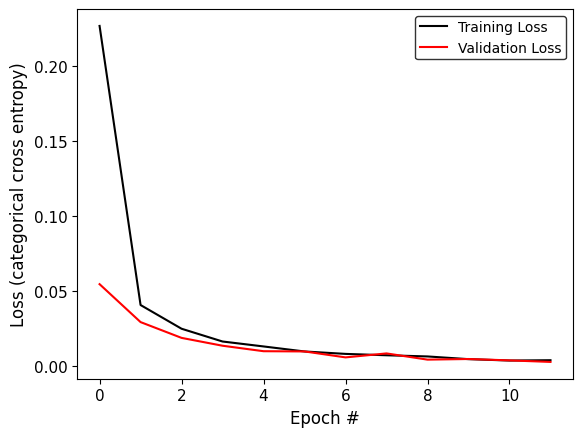

In [ ]:
plt.plot(range(0,num_epochs), history.history['loss'], c='k')
plt.plot(range(0,num_epochs), history.history['val_loss'], c='r')
plt.xlabel('Epoch #', fontname = 'Arial', fontsize = 12)
plt.ylabel('Loss (categorical cross entropy)', fontname = 'Arial', fontsize = 12)
plt.xticks(fontname = 'Arial', fontsize = 11)
plt.yticks(fontname = 'Arial', fontsize = 11)
plt.legend(['Training Loss','Validation Loss'],prop={'family':'Arial'}, fontsize = 8, edgecolor = 'black', borderpad = 0.3)
plt.show()

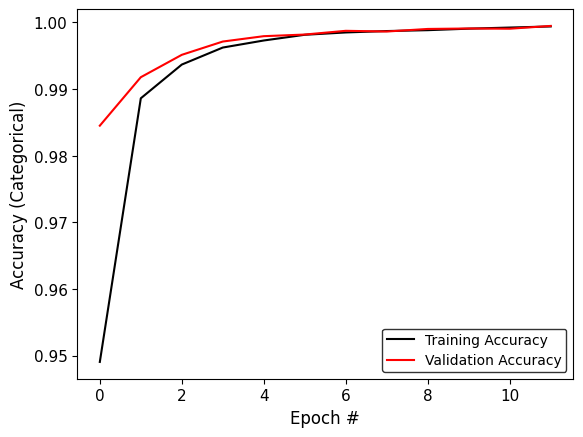

In [ ]:
plt.plot(range(0,num_epochs), history.history['categorical_accuracy'], c='k')
plt.plot(range(0,num_epochs), history.history['val_categorical_accuracy'], c='r')
plt.xlabel('Epoch #', fontname = 'Arial', fontsize = 12)
plt.ylabel('Accuracy (Categorical)', fontname = 'Arial', fontsize = 12)
plt.xticks(fontname = 'Arial', fontsize = 11)
plt.yticks(fontname = 'Arial', fontsize = 11)
plt.legend(['Training Accuracy','Validation Accuracy'],prop={'family':'Arial'}, fontsize = 8, edgecolor = 'black', borderpad = 0.3)
plt.show()

In [ ]:
label_pred = np.zeros(input_test.shape[0])
label_test_pred = np.zeros(input_test.shape[0])
def decode(values):
  max = 0
  answer = values[0]
  for i in range(len(values)):
    if values[i] > max:
      max = values[i]
      answer = i+1
  return answer
predictions = model.predict(input_test)
correct = 0
for i in range(len(predictions)):
  label_pred[i] = decode(predictions[i])
  label_test[i] = decode(encoded_label_test[i])
  if (decode(predictions[i]) == decode(encoded_label_test[i])):
    correct += 1
  #print("prediction: " + str(decode(predictions[i])) + ", " + "actual: " + str(decode(encoded_label_test[i])))

print("accuracy = " + str(correct/len(predictions)))

2978/2978 [==============================] - 4s 1ms/step
accuracy = 0.9992022839869007


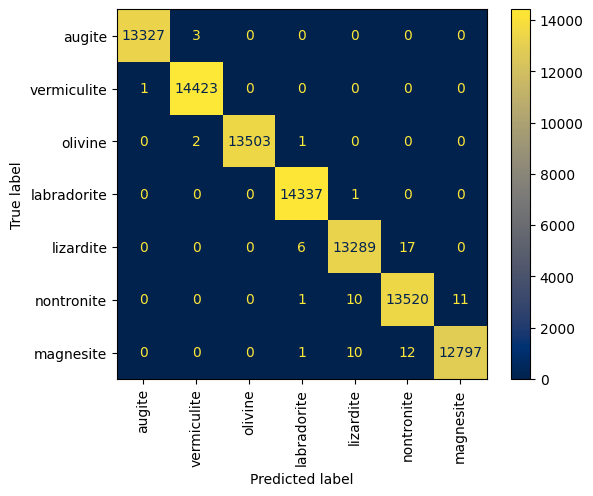

In [ ]:
con_matrix = sklearn.metrics.confusion_matrix(label_test, label_pred)
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = con_matrix, display_labels = ['augite','vermiculite','olivine','labradorite','lizardite','nontronite','magnesite'])
cm_display.plot(xticks_rotation = 'vertical', cmap = 'cividis')
plt.show()